## PORTFOLIO MANAGEMENT ON PREDICTED CLOSING PRICES

We perform portfolio management in 50 tickers from S&P 500 stocks picked randomly. We have reduced the number so that it is easy to analyse the data. The approach can be extended to any number of stocks.

### Import the required libraries

In [1]:
!pip install pandas==0.25

     |████████████████████████████████| 10.5 MB 1.3 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.1
    Uninstalling pandas-0.25.1:
      Successfully uninstalled pandas-0.25.1


In [2]:
import pandas
pandas.__version__


'0.25.0'

In [3]:
import sys
import os
sys.path.append(os.getcwd())

In [4]:
def add_datepart(df, fldnames, drop=True, time=False, errors="raise"):	
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.
    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string or list of strings that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.
    Examples:
    ---------
    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df
        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13
    >>> add_datepart(df, 'A')
    >>> df
        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    >>>df2 = pd.DataFrame({'start_date' : pd.to_datetime(['3/11/2000','3/13/2000','3/15/2000']),
                            'end_date':pd.to_datetime(['3/17/2000','3/18/2000','4/1/2000'],infer_datetime_format=True)})
    >>>df2
        start_date	end_date    
    0	2000-03-11	2000-03-17
    1	2000-03-13	2000-03-18
    2	2000-03-15	2000-04-01
    >>>add_datepart(df2,['start_date','end_date'])
    >>>df2
    	start_Year	start_Month	start_Week	start_Day	start_Dayofweek	start_Dayofyear	start_Is_month_end	start_Is_month_start	start_Is_quarter_end	start_Is_quarter_start	start_Is_year_end	start_Is_year_start	start_Elapsed	end_Year	end_Month	end_Week	end_Day	end_Dayofweek	end_Dayofyear	end_Is_month_end	end_Is_month_start	end_Is_quarter_end	end_Is_quarter_start	end_Is_year_end	end_Is_year_start	end_Elapsed
    0	2000	    3	        10	        11	        5	            71	            False	            False	                False	                False	                False	            False	            952732800	    2000	    3	        11	        17	    4	            77	            False	            False	            False	            False	                False	        False	            953251200
    1	2000	    3	        11	        13	        0	            73	            False	            False	                False	                False               	False           	False           	952905600     	2000       	3	        11      	18  	5           	78          	False	            False           	False           	False               	False          	False           	953337600
    2	2000	    3	        11	        15	        2           	75          	False           	False               	False               	False               	False               False           	953078400      	2000    	4          	13      	1   	5           	92          	False           	True            	False           	True                	False          	False           	954547200
    """
    if isinstance(fldnames,str): 
        fldnames = [fldnames]
    for fldname in fldnames:
        fld = df[fldname]
        fld_dtype = fld.dtype
        if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            fld_dtype = np.datetime64

        if not np.issubdtype(fld_dtype, np.datetime64):
            df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
        targ_pre = re.sub('[Dd]ate$', '', fldname)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
                'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
        df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
        if drop: df.drop(fldname, axis=1, inplace=True)

In [5]:
!pip install pytrends

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from stocker import Stocker
#from fastai.old.fastai.structured import add_datepart
import numpy
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import quandl 

Importing plotly failed. Interactive plots will not work.


### Get previous closing prices for stocks

The porfolio management analysis is not restricted to only predicted stock values. Initially for our EDA we used the historical stock prices of 6 tickers. We take 3 month range starting from 03-01-2017 to 06-01-2017. 

In [7]:
import re

In [8]:
quandl.ApiConfig.api_key = 'FyiJeGX71L9ijqorzmmP'

def get_stock_prices(stocks_data, companies, start_date, end_date):
    date_range = (start_date, end_date)
    tickers = companies
    tickerobjs = {} 
    for ticker in tickers:
        tickerobjs[ticker] = (Stocker(ticker=ticker))

    for i, (k, v) in enumerate(tickerobjs.items()): 
        print(i, k, v)
    
    count = 1000

    for i, (ticker, stocker) in enumerate(tickerobjs.items()):
        df = stocker.make_df(date_range[0], date_range[1])
        # ddd date features
        add_datepart(df, 'Date', drop=False)
        # drop unwanted columns date feature columns
        df = df.drop(['Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'], axis=1)
        df['Is_month_end'] = df['Is_month_end'].astype(int)
        df['Is_month_start'] = df['Is_month_start'].astype(int)
        # setting index as date
        df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
        df.index = df['Date']
        # sort df by date
        df = df.sort_index(ascending=True, axis=0)

        stocks_data[ticker] = df['Adj. Close']

In [9]:
companies = ['INTL', 'QCOM', 'FB', 'AMZN', 'MCD', 'WFC']
stocks_data = {}
get_stock_prices(stocks_data, companies, '03-01-2017', '06-01-2017')

/home/shikha/Desktop/Shikha/equity-portfolio-prediction/stocker.py:70: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  self.starting_price = float(self.stock.ix[0, 'Adj. Open'])
/home/shikha/Desktop/Shikha/equity-portfolio-prediction/stocker.py:73: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  self.most_recent_price = float(self.stock.ix[len(self.stock) - 1, 'y'])


INTL Stocker Initialized. Data covers 1996-11-15 to 2018-03-27.
QCOM Stocker Initialized. Data covers 1991-12-16 to 2018-03-27.
FB Stocker Initialized. Data covers 2012-05-18 to 2018-03-27.
AMZN Stocker Initialized. Data covers 1997-05-16 to 2018-03-27.
MCD Stocker Initialized. Data covers 1970-01-02 to 2018-03-27.
WFC Stocker Initialized. Data covers 1972-06-01 to 2018-03-27.
0 INTL <stocker.Stocker object at 0x7f19b821db70>
1 QCOM <stocker.Stocker object at 0x7f19ba538a58>
2 FB <stocker.Stocker object at 0x7f19edead128>
3 AMZN <stocker.Stocker object at 0x7f19eab3d240>
4 MCD <stocker.Stocker object at 0x7f19b821d978>
5 WFC <stocker.Stocker object at 0x7f19edea2320>


/home/shikha/Desktop/Shikha/equity-portfolio-prediction/stocker.py:178: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  trim_df = df[(df['Date'] >= start_date.date()) &
/home/shikha/Desktop/Shikha/equity-portfolio-prediction/stocker.py:179: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  (df['Date'] <= end_date.date())]


In [10]:
stocks_data

{'INTL': Date
 2017-03-01    39.17
 2017-03-02    38.49
 2017-03-03    38.25
 2017-03-06    38.01
 2017-03-07    37.91
               ...  
 2017-05-25    34.81
 2017-05-26    34.95
 2017-05-30    34.79
 2017-05-31    34.56
 2017-06-01    34.60
 Name: Adj. Close, Length: 65, dtype: float64,
 'QCOM': Date
 2017-03-01    55.374710
 2017-03-02    54.753068
 2017-03-03    54.821060
 2017-03-06    54.830773
 2017-03-07    55.102742
                 ...    
 2017-05-25    56.773405
 2017-05-26    56.423731
 2017-05-30    56.247162
 2017-05-31    56.178496
 2017-06-01    57.502766
 Name: Adj. Close, Length: 65, dtype: float64,
 'FB': Date
 2017-03-01    137.42
 2017-03-02    136.76
 2017-03-03    137.17
 2017-03-06    137.42
 2017-03-07    137.30
                ...  
 2017-05-25    151.96
 2017-05-26    152.13
 2017-05-30    152.38
 2017-05-31    151.46
 2017-06-01    151.53
 Name: Adj. Close, Length: 65, dtype: float64,
 'AMZN': Date
 2017-03-01    853.08
 2017-03-02    848.91
 2017-03-03  

### Preparing the dataframe

In [11]:
def build_data(stocks_data):
    data = pd.DataFrame()
    for k in stocks_data:
        data[k] = stocks_data[k]
    return data


#### This code should be uncommented if historical data is fetched from Quandal to get portfolio

In [20]:
#data = build_data(stocks_data)
#returns = data.pct_change()[1:]

#### Following snippet reads the predicted Adj. Closing price values generated from LSTM

We take one quater of data i.e. 90 days to bulilt our portfolio for 50 tickers.

In [12]:
data = pd.read_csv('predicted_adj_close_50.csv')
data.index = data['Date']
data = data.drop('Date',1)
data = data.sort_index(ascending=True, axis=0)
data = data.iloc[0:91]
returns = data.pct_change()[1:]
len(returns)

90

In [13]:
returns

,amgn,gd,nwl,zion,mat,vno,sbac,flir,wfc,aee,...,amp,ndaq,ual,apa,re,gww,dte,cf,aig,msci
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-08,-0.004187,-0.002171,-0.009437,-0.008434,-0.004149,-0.001434,0.000687,-0.003073,-0.005088,-0.003132,...,0.004792,0.012546,0.001473,0.000433,0.005208,0.018875,-0.002525,0.030731,-0.005232,-0.004489
2017-05-09,0.005446,0.002216,0.010914,0.000461,0.016605,0.005985,-0.001830,0.002420,0.008095,0.003551,...,0.036411,0.019858,0.015920,0.014923,0.012605,0.018969,0.004755,0.029367,0.005190,0.018928
2017-05-10,0.005077,0.003764,0.012774,0.007460,0.008459,-0.000546,0.007622,0.004524,0.005637,0.003240,...,0.022692,0.013065,0.006170,0.011703,0.010743,0.015546,0.006605,0.014326,0.012173,0.010233
2017-05-11,0.002005,0.000791,0.012239,0.004653,0.001661,-0.000190,0.005145,0.003852,0.001024,0.000041,...,0.011600,0.005668,0.000177,0.006956,0.010935,0.009043,0.005039,0.005969,0.010137,0.000914
2017-05-12,-0.002751,-0.001859,0.006551,-0.001518,-0.007761,-0.003410,0.003911,0.001481,-0.004792,-0.002318,...,0.001815,0.001101,-0.003286,0.000845,0.007864,0.003671,0.002395,0.000783,0.002649,-0.006395
2017-05-15,-0.007229,-0.003279,0.000828,-0.010986,-0.014479,-0.003775,0.002190,-0.001924,-0.009625,-0.003946,...,-0.006394,-0.001537,-0.005369,-0.005615,0.004840,-0.000621,-0.000533,-0.002236,-0.007748,-0.011156
2017-05-16,0.002220,0.001076,0.012153,-0.001973,0.010549,0.002846,-0.003871,0.004220,0.003862,0.002585,...,0.024089,0.008271,0.011423,0.012440,0.012634,0.005216,0.006469,0.003495,0.004242,0.014304
2017-05-17,0.002702,0.002603,0.006372,0.005203,-0.005207,-0.001635,0.002267,0.006112,0.003744,0.002832,...,0.015005,0.005156,0.003046,0.009137,0.011053,0.002097,0.008269,-0.002622,0.011157,0.007987
2017-05-18,0.000509,-0.000402,0.002129,-0.000368,-0.002706,-0.002705,0.001739,0.003170,-0.002367,-0.000191,...,0.006879,0.001086,-0.001666,0.002514,0.007377,0.000670,0.006409,-0.004762,0.009042,-0.000577


In [14]:
companies = data.columns
#companies = list(map(lambda x: x.upper(), companies))
companies = list(companies)
len(companies)

50

In [15]:
companies

['amgn',
 'gd',
 'nwl',
 'zion',
 'mat',
 'vno',
 'sbac',
 'flir',
 'wfc',
 'aee',
 'fcx',
 'ksu',
 'mtb',
 'duk',
 'tss',
 'etr',
 'pnr',
 'incy',
 'regn',
 'mdlz',
 'wynn',
 'pep',
 'dva',
 'ads',
 'mnst',
 'sti',
 'akam',
 'tfx',
 'wat',
 'antm',
 'hon',
 'o',
 'usb',
 'ma',
 'rtn',
 'sna',
 'dre',
 'csx',
 'pcar',
 'pru',
 'amp',
 'ndaq',
 'ual',
 'apa',
 're',
 'gww',
 'dte',
 'cf',
 'aig',
 'msci']

### Check returns for any ticker

#### Time series of Returns

The following plots show time series of return of ticker 'vno' ie 'Vornado Realty Trust'. It can be seen that returns have declined in late July'17. Similarly teh distribution of returns can be seen in next plot.

Analyzing returns for:  vno


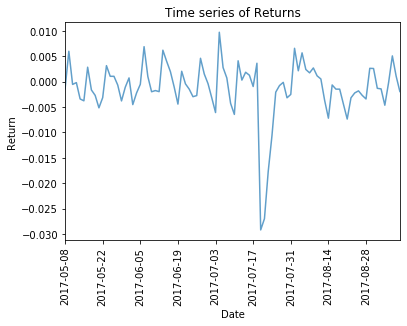

In [16]:
ticker = companies[5]
print("Analyzing returns for: ", ticker)
plt.title('Time series of Returns')
returns[ticker].plot(alpha=0.7)
plt.xticks(rotation=90)
plt.ylabel("Return")
plt.show()

Analyzing returns for:  vno


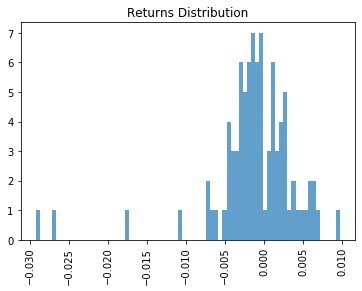

In [17]:
print("Analyzing returns for: ", ticker)
plt.hist(returns[ticker].dropna(), bins=75, density=False, alpha=0.7)
plt.title('Returns Distribution')
plt.xticks(rotation=90)
plt.show()

### Calculating covariance and correlation between stocks

We calculate correlation and covariance matrix for the given list of tickers.
Correlation is a measure of how strongly the stocks are related. If correlation value for any pair of stocks is more than 0.5 we should not put them in same porfolio. This is because if 2 stocks are highly corrleated and one falls the other will fall as well and result in overall loss in porfolio. In order to keep the porfolio balanced we take consider unrelated stocks in a porfolio.

For same reason we set a threshold in Covariance value as well. If covraiance of a stock pair is greater than mean covariance we cannot put them same portfolio.

In [18]:
Covariance = returns.cov()
Correlation = returns.corr()
np.round(Correlation,3)

,amgn,gd,nwl,zion,mat,vno,sbac,flir,wfc,aee,...,amp,ndaq,ual,apa,re,gww,dte,cf,aig,msci
amgn,1.000,0.638,0.509,0.606,0.160,0.200,-0.023,0.325,0.736,0.716,...,0.665,0.574,0.554,0.594,0.583,0.549,0.670,0.433,0.588,0.402
gd,0.638,1.000,0.651,0.517,0.397,0.362,-0.043,0.391,0.749,0.857,...,0.579,0.426,0.695,0.696,0.454,0.407,0.620,0.433,0.730,0.731
nwl,0.509,0.651,1.000,0.455,0.480,0.378,-0.328,0.337,0.744,0.641,...,0.540,0.200,0.628,0.411,0.406,0.143,0.481,0.141,0.358,0.553
zion,0.606,0.517,0.455,1.000,0.108,0.226,0.188,0.140,0.667,0.506,...,0.403,0.332,0.235,0.318,0.409,0.292,0.593,0.121,0.370,0.159
mat,0.160,0.397,0.480,0.108,1.000,0.190,-0.289,0.394,0.396,0.257,...,0.082,-0.152,0.285,0.120,-0.018,-0.162,0.068,-0.082,0.177,0.413
vno,0.200,0.362,0.378,0.226,0.190,1.000,-0.302,-0.135,0.376,0.373,...,0.353,0.231,0.499,0.379,0.184,0.162,0.182,0.291,0.285,0.480
sbac,-0.023,-0.043,-0.328,0.188,-0.289,-0.302,1.000,0.004,-0.318,-0.100,...,-0.087,0.143,-0.397,-0.031,0.080,0.237,0.138,0.063,0.052,-0.409
flir,0.325,0.391,0.337,0.140,0.394,-0.135,0.004,1.000,0.307,0.279,...,0.056,-0.048,0.114,0.069,0.132,-0.023,0.294,-0.090,0.286,0.188
wfc,0.736,0.749,0.744,0.667,0.396,0.376,-0.318,0.307,1.000,0.730,...,0.630,0.357,0.635,0.532,0.532,0.286,0.616,0.255,0.548,0.626
aee,0.716,0.857,0.641,0.506,0.257,0.373,-0.100,0.279,0.730,1.000,...,0.747,0.683,0.878,0.822,0.572,0.620,0.748,0.608,0.716,0.703


#### Heat Map for correlations

The following heat map shows that tickers with darker colors are not correlated and can be in a porfolio.

In [19]:
def correlation_matrix_plot(matrix, maptype):
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    if (maptype == 'cmap'):
        cax = ax1.imshow(matrix, interpolation="nearest", cmap=cmap, alpha=0.7)
    else:
        cax = ax1.imshow(matrix, interpolation="nearest", cmap=maptype, alpha=0.7)
    ax1.grid(True)
    plt.title('Stocks Correlation')
    ax1.set_xticks(np.arange(len(companies)))
    ax1.set_yticks(np.arange(len(companies)))
    ax1.set_xticklabels(companies,fontsize=10,rotation=90)
    ax1.set_yticklabels(companies,fontsize=10)
    ax1.set_alpha(0.4)
    ticks = numpy.arange(0,9,1)
    fig.colorbar(cax)
    plt.show()

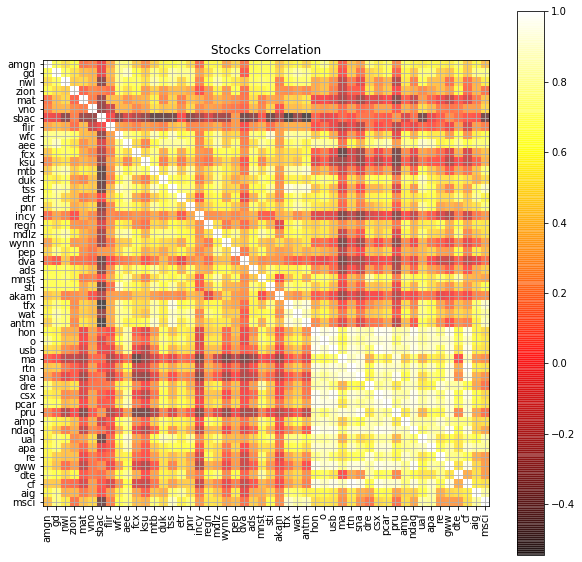

In [20]:
correlation_matrix_plot(Correlation,'hot')

#### Another represenation for correlation

The tickers that are blue have correlation less than 0.5 and can be in same portfolio.

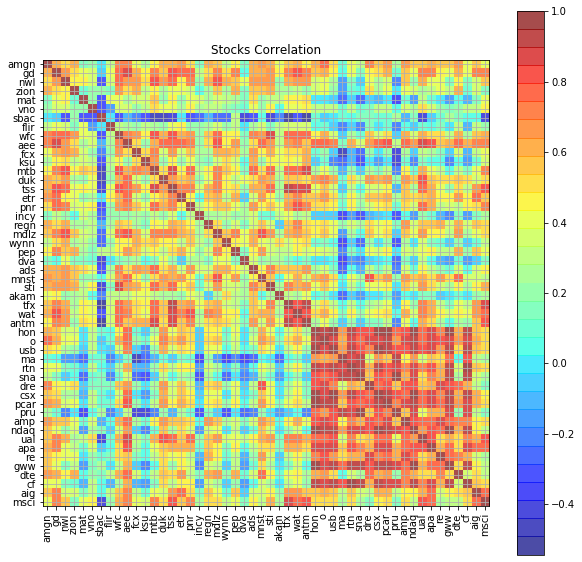

In [21]:
correlation_matrix_plot(Correlation,'cmap')

#### Check if a particular pair of stock can be paired together

If a pair of stock meets both Covariance and correlation thersholds then they can be paired together. The plot below shows pairable stocks in blue and unpairable ones in green.

In [22]:
mean_Covariance = Covariance.mean()

In [23]:
def get_pairable(data, Covariance, Correlation):
    Pairable = np.zeros(Covariance.shape)
    plt.figure(figsize=(16,7))

    for i in range(len(companies)):
        for j in range(len(companies)-i):
            if(Covariance[i,j] > mean_Covariance[i] or Covariance[i,j] > mean_Covariance[j] or Correlation[i][j]>0.5):
                plt.plot(i, j, 'o', color='green', alpha=0.5) 
            else:
                plt.plot(i, j, 'o', color='blue', alpha=0.5)
                Pairable[i,j] = 1

    plt.xlim(-1,len(companies)+1)
    plt.ylim(-1,len(companies)+1)
    plt.xticks(range(len(companies)), companies, rotation=40)    
    plt.yticks(range(len(companies)), companies)
    #plt.set_xticklabels(companies,fontsize=10,rotation=40)
    plt.legend()
    return Pairable

No handles with labels found to put in legend.


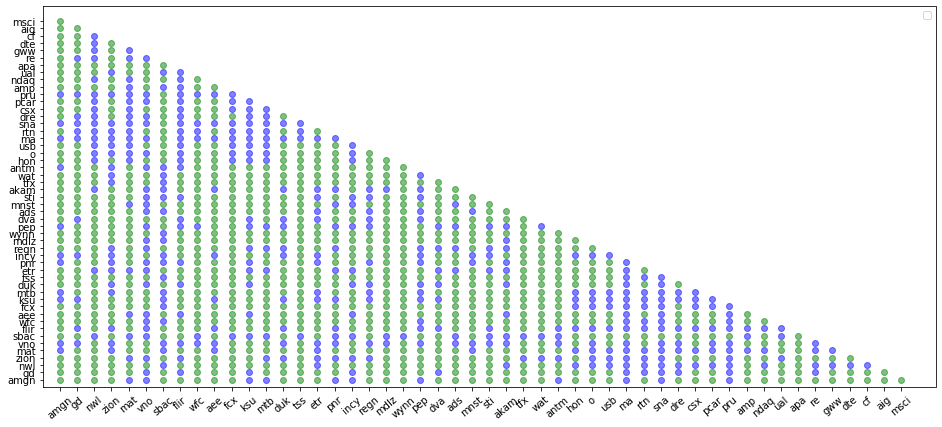

In [24]:
Pairable = get_pairable(data,np.array(Covariance), np.array(Correlation))

#### Calculating Shapre Ratio of a portfolio

"The Sharpe ratio is calculated by subtracting the risk-free rate from the return of the portfolio and dividing that result by the standard deviation of the portfolio’s excess return."

Sharpe_ratio = (Rp - Rf)/SigmaP

Rp: return of portfolio/mean return

Rf: risk-free rate of 2% ie current risk free rate of US market

SigmaP: standard deviation of the portfolio’s excess return

A higher value of Sharpe ratio means better risk-adjusted return. 

Sharpe ratio > 1 is considered good

Sharpe ratio > 2 is considered very good

Sharpe ratio > 3 is considered excellent

In [25]:
Rf = 2/100  #risk_free_rate
stocks_rng = range(len(companies))

def sharpe_ratio(pair, portfolio_weights, meanR, cov):    
    Rp = portfolio_weights.dot(meanR.T) 
    SigmaP = portfolio_weights.dot(cov.dot(portfolio_weights.T)) * len(returns)
    s_ratio = (Rp - Rf)/np.sqrt(SigmaP)
    return s_ratio

# portfolio_volatility = np.sqrt(np.dot(portfolio_weights.T, 
#                             np.dot(cov_mat_annual, portfolio_weights)))

#### Checking whether other stocks can be added to selected pair

Every other stock that is not correlated to th pair can be in same portfolio as pair.

In [26]:
def check_pairs(pair):
    not_in_pair = []
    for i in stocks_rng:
        if(i not in pair):
            not_in_pair.append(i)
        else:
            continue
            
    for tick in not_in_pair:
        total_pair = len(pair)
        for i in pair:
            if(Pairable[tick,i]!=1 or Pairable[i,tick]!=1):
                total_pair -= 1
        if(float(total_pair)/len(pair) > 0.5):
            pair.add(tick)              
    return pair

#### Selecting optimized portfolios

We create all possible combinations of pairs in given list of tickers. For example for n tickers possible pairs can be nC2. 

For each pair we check which other stock can be added together by checking it's correlation and covariance values, and add them in same portfolio.

Portfolis with good, better, best Sharpe Ratio is saved seperately.

In [27]:
portfolio_collection = []
optim = {'good':[],'better':[],'best': []}

def select(combo):
    pair = set(combo)
    pair = check_pairs(pair)
    #print("new pair by checking pairable: ", pair)
    if pair in portfolio_collection:
        #print('returning')
        return
    portfolio_collection.append(pair)
    #print("portfoilio: ", portfolio_collection)
    sharpe_r = 0
    eff_weights = np.ones(len(pair))

    symbols = [companies[s] for s in pair]        
    mean_returns = np.array(returns[symbols].mean()) * len(returns)
    sub_cov_mat = np.array(returns[symbols].cov())        

    for _ in range(200):
        weights = [np.random.randint(50,500) for _ in pair]
        weights = np.array(weights, dtype=float)
        weights /= weights.sum()
        s_r = sharpe_ratio(pair, weights, mean_returns, sub_cov_mat)
        if( s_r > sharpe_r):
            sharpe_r = s_r
            eff_weights = weights
        
    if (sharpe_r >= 1 and sharpe_r < 2) :
        optim['good'].append([[companies[s] for s in pair],eff_weights,sharpe_r])
    if (sharpe_r >= 2 and sharpe_r < 3) :
        optim['better'].append([[companies[s] for s in pair],eff_weights,sharpe_r])
    if(sharpe_r >=3) :
        optim['best'].append([[companies[s] for s in pair],eff_weights,sharpe_r])

In [28]:
from itertools import combinations
count=0
run = list(combinations(stocks_rng,2))
for combo in run:
    count +=1
    if(Pairable[combo[0],combo[1]]!=1 or Pairable[combo[1],combo[0]]!=1):
        continue
    else:
        #print("taking the combo")
        select(combo)
print("number of combinations: ", count)

number of combinations:  1225


In [29]:
optim['good']

[[['amgn', 'ksu', 'pnr', 'regn', 'pep', 'dva'],
  array([0.23717949, 0.26730769, 0.03397436, 0.26794872, 0.12884615,
         0.06474359]),
  1.0953518409347007],
 [['ma', 'nwl', 'sbac', 'etr', 'pnr', 'akam'],
  array([0.3540175 , 0.26491647, 0.12728719, 0.0708035 , 0.11933174,
         0.0636436 ]),
  1.7401298469972128],
 [['nwl', 'dre'], array([0.09925094, 0.90074906]), 1.7955968545402865],
 [['nwl', 'pru'], array([0.17887564, 0.82112436]), 1.0478238764774166],
 [['nwl', 'gww'], array([0.11627907, 0.88372093]), 1.3008881785021214],
 [['ma', 'zion', 'vno', 'flir', 'aee', 'duk', 'pnr', 'regn', 'pep', 'akam'],
  array([0.22985634, 0.17426608, 0.04372267, 0.03497814, 0.12929419,
         0.03997502, 0.13241724, 0.09931293, 0.08244847, 0.03372892]),
  1.1757063289266394],
 [['ma', 'zion', 'vno', 'flir', 'duk', 'pnr', 'regn', 'pep', 'dva', 'akam'],
  array([0.16189759, 0.17771084, 0.03840361, 0.03990964, 0.02597892,
         0.1125753 , 0.17243976, 0.1622741 , 0.08584337, 0.02296687]),
  

In [30]:
optim['better']

[[['amgn', 'ma', 'sna', 'mat', 'vno', 'aee', 'ksu', 'etr', 'pnr'],
  array([0.1818854 , 0.17855823, 0.16561922, 0.03031423, 0.04879852,
         0.08465804, 0.13197782, 0.12347505, 0.05471349]),
  2.436253622219266],
 [['amgn', 'ma', 'sna', 'mat', 'vno', 'pru', 'aee', 'ksu'],
  array([0.06857977, 0.21498054, 0.21838521, 0.057393  , 0.07733463,
         0.08949416, 0.09922179, 0.17461089]),
  2.748308120756635],
 [['amgn', 'ma', 'sna', 'mat', 'vno', 'pru', 'aee'],
  array([0.07894737, 0.23976608, 0.27426901, 0.06549708, 0.07076023,
         0.1251462 , 0.14561404]),
  2.7099980593045596],
 [['gd', 'ma', 'sna', 'vno', 'flir', 'pru', 'aee'],
  array([0.08042152, 0.24181919, 0.24070993, 0.05657238, 0.10205214,
         0.13200222, 0.14642263]),
  2.9439141680506515],
 [['gd', 'ma', 'sna', 'vno', 'flir', 'aee', 'ksu', 'duk', 'pnr', 'pep', 'dva'],
  array([0.09822588, 0.15447858, 0.17005625, 0.02596279, 0.02942449,
         0.02466465, 0.13111207, 0.09736045, 0.12765037, 0.11337084,
        

In [31]:
optim['best']

[[['amgn', 'ma', 'sna', 'mat'],
  array([0.15477387, 0.27939698, 0.49447236, 0.07135678]),
  3.7107904469003934],
 [['amgn', 'ma', 'mtb', 'pep'],
  array([0.07730426, 0.43409316, 0.06243806, 0.42616452]),
  3.880803499611723],
 [['gd', 'ksu', 'dva', 'ma'],
  array([0.11600587, 0.24522761, 0.07929515, 0.55947137]),
  4.00706601461209],
 [['gd', 'ma', 'flir', 'ksu', 'duk', 'regn', 'pep', 'dva'],
  array([0.03531892, 0.24090669, 0.08381655, 0.15023722, 0.09804955,
         0.14443859, 0.07749077, 0.1697417 ]),
  3.078995189573192],
 [['gd', 'rtn', 'ma', 'flir', 'ksu', 'dva'],
  array([0.15478762, 0.12958963, 0.35133189, 0.07415407, 0.20806335,
         0.08207343]),
  3.4536512255719436],
 [['gd', 'ma', 'sna', 'vno', 'flir', 'aee', 'ksu', 'duk', 'pep', 'dva'],
  array([0.04311039, 0.16720387, 0.16317486, 0.03102337, 0.02215955,
         0.05600322, 0.19863014, 0.0475423 , 0.12409347, 0.14705882]),
  3.309715005970349],
 [['gd', 'ma', 'sna', 'dre', 'vno', 'flir'],
  array([0.08036293, 0.27

In [32]:
portfolio_collection

[{0, 4, 33, 35},
 {0, 5, 16, 18, 21, 23, 26},
 {0, 11, 16, 18, 21, 22},
 {0, 12, 21, 33},
 {0, 5, 6, 11, 15, 16, 21, 23, 26, 33},
 {0, 17, 21, 25},
 {0, 5, 7, 13, 16, 18, 21, 22, 26, 33},
 {0, 5, 6, 16, 21, 26, 29},
 {0, 4, 5, 9, 11, 15, 16, 33, 35},
 {0, 4, 5, 9, 11, 33, 35, 39},
 {0, 4, 5, 9, 33, 35, 39},
 {1, 5, 7, 9, 33, 35, 39},
 {1, 11, 22, 33},
 {1, 17},
 {1, 7, 11, 13, 18, 21, 22, 33},
 {1, 5, 7, 9, 11, 13, 16, 21, 22, 33, 35},
 {1, 7, 11, 22, 33, 34},
 {1, 5, 7, 9, 11, 13, 21, 22, 33, 35},
 {1, 5, 7, 33, 35, 36},
 {1, 5, 7, 33, 35, 44},
 {2, 6, 26},
 {2, 15, 26, 33},
 {2, 6, 15, 16, 26, 33},
 {2, 30},
 {2, 31},
 {2, 32},
 {2, 15, 16, 26, 33},
 {2, 34},
 {2, 35},
 {2, 36},
 {2, 37},
 {2, 38},
 {2, 39},
 {2, 41},
 {2, 44},
 {2, 45},
 {2, 46},
 {2, 47},
 {3, 4, 15, 16, 33},
 {3, 5, 7, 9, 13, 16, 18, 21, 26, 33},
 {3, 12, 15, 16, 18, 21, 26, 33},
 {3, 5, 7, 13, 16, 18, 21, 22, 26, 33},
 {3, 4, 5, 15, 16, 18, 26, 33},
 {3, 5, 6, 7, 13, 16, 18, 21, 25, 26},
 {3, 13, 15, 17, 33},
 {3

In [33]:
better = pd.DataFrame.from_dict(optim['better'])
better.columns = ['Portfolio', 'Weights', 'Sharpe Ratio']

In [34]:
portfolio_return = []

for row in better.iterrows():
    #print(row[1][0])
    mean = np.array(returns[row[1][0]].mean()) * len(returns)
    #mean = ((1+np.mean(returns[row[1][0]]))**252)-1 #annulazied return for 252 trading days
    portfolio_weights = np.array(row[1][1])
    Rp = portfolio_weights.dot(mean.T) 
    portfolio_return.append(round(Rp * 100, 2))
    #print('Rp:', Rp)
    
better['Portfolio Return'] = portfolio_return

In [35]:
better['Portfolio Return']

0      9.34
1     11.04
2     12.94
3     13.09
4      8.28
5     10.72
6      8.73
7     23.58
8     22.79
9      8.53
10     7.01
11    13.85
12    13.07
13    11.13
14    21.28
15     9.80
16     8.39
17    16.95
18     8.92
19    10.53
20     9.47
21    10.26
22    10.90
23    27.43
24    22.35
25    22.92
26    11.08
27     7.85
28    11.61
29     9.18
30    25.04
31     8.84
32    13.53
Name: Portfolio Return, dtype: float64

In [36]:
portfolio_volatility = []

for row in better.iterrows():
    portfolio = row[1][0]
    portfolio_weights = row[1][1]
    portfolio_data = data[portfolio]
    portfolio = portfolio_data.mul(portfolio_weights,axis=1).sum(axis=1)
    volatility = np.std(portfolio)
    portfolio_volatility.append(volatility)

better['Portfolio Volatility'] = portfolio_volatility
better

,Portfolio,Weights,Sharpe Ratio,Portfolio Return,Portfolio Volatility
0,"[amgn, ma, sna, mat, vno, aee, ksu, etr, pnr]","[0.18188539741219964, 0.17855822550831793, 0.1...",2.436254,9.34,3.311749
1,"[amgn, ma, sna, mat, vno, pru, aee, ksu]","[0.06857976653696499, 0.21498054474708173, 0.2...",2.748308,11.04,3.715669
2,"[amgn, ma, sna, mat, vno, pru, aee]","[0.07894736842105263, 0.23976608187134502, 0.2...",2.709998,12.94,4.293280
3,"[gd, ma, sna, vno, flir, pru, aee]","[0.08042151968940654, 0.2418191902384914, 0.24...",2.943914,13.09,3.804206
4,"[gd, ma, sna, vno, flir, aee, ksu, duk, pnr, p...","[0.0982258762440502, 0.15447858070099524, 0.17...",2.763297,8.28,2.621050
5,"[ma, nwl, akam, etr]","[0.515358361774744, 0.23208191126279865, 0.075...",2.812387,10.72,2.783166
6,"[ma, nwl, etr, pnr, akam]","[0.45802238805970147, 0.05690298507462686, 0.2...",2.292390,8.73,2.345464
7,"[nwl, rtn]","[0.10526315789473684, 0.8947368421052632]",2.871136,23.58,7.568515
8,"[ndaq, nwl]","[0.9041353383458647, 0.09586466165413533]",2.038727,22.79,3.501016
9,"[ma, zion, mat, etr, pnr]","[0.39304347826086955, 0.17130434782608694, 0.0...",2.094147,8.53,2.313388


/home/shikha/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


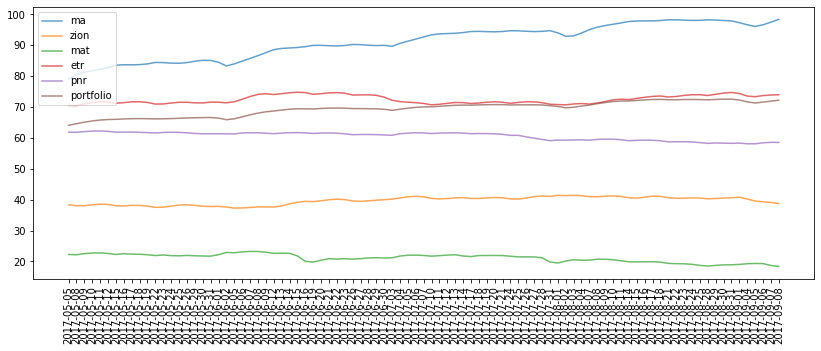

In [37]:
def plot_volatility(portfolio, weights):
    portfolio_data = data[portfolio]
    volatility = portfolio_data.mul(weights,axis=1).sum(axis=1)
    portfolio_data['portfolio'] = volatility
    plt.figure(figsize=(14,5))
    plt.plot(portfolio_data.index, portfolio_data,alpha=0.7)
    plt.legend(portfolio + ['portfolio'])
    plt.xticks(rotation=90)
    plt.show()

plot_volatility(better['Portfolio'][9], better['Weights'][9])

In [38]:
better['PortfolioL'] = better['Portfolio'].apply(lambda x: ','.join(map(str, x)))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 1008x360 with 0 Axes>

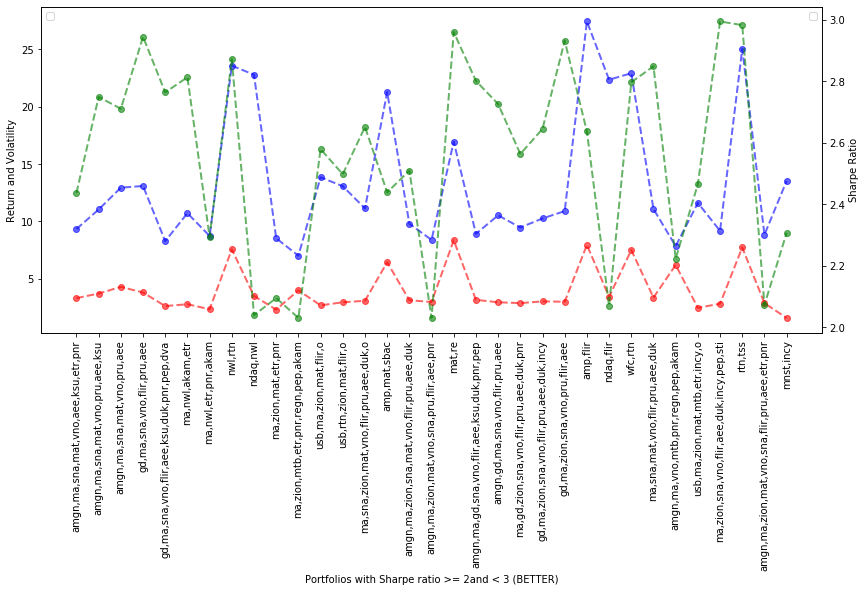

In [39]:
plt.figure(figsize=(14,5))
fig, ax1 = plt.subplots(figsize=(14,6))

ax2 = ax1.twinx()
ax2.plot(better['PortfolioL'], better['Sharpe Ratio'], 'g-', alpha=0.6, marker='o', 
         linestyle='dashed', linewidth=2, markersize=6)
ax1.plot(better['PortfolioL'], better['Portfolio Return'], 'b-', alpha=0.6, marker='o', 
         linestyle='dashed', linewidth=2, markersize=6)
ax1.plot(better['PortfolioL'],better['Portfolio Volatility'], 'r-', alpha=0.6, marker='o', 
         linestyle='dashed', linewidth=2, markersize=6)

ax1.set_xlabel('Portfolios with Sharpe ratio >= 2and < 3 (BETTER)')
ax1.set_ylabel('Return and Volatility')
ax2.set_ylabel('Sharpe Ratio')
ax1.xaxis.set_tick_params(rotation=90)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax2.set_alpha(0.4)
ax1.set_alpha(0.4)
plt.show()


In [49]:
good = pd.DataFrame.from_dict(optim['good'])
good.columns = ['Portfolio', 'Weights', 'Sharpe Ratio']
portfolio_return = []

for row in good.iterrows():
    #print(row[1][0])
    mean = np.array(returns[row[1][0]].mean()) * len(returns)
    portfolio_weights = np.array(row[1][1])
    Rp = portfolio_weights.dot(mean.T) 
    portfolio_return.append(round(Rp * 100, 2))
    
good['Portfolio Return'] = portfolio_return

portfolio_volatility = []

for row in good.iterrows():
    portfolio = row[1][0]
    portfolio_weights = row[1][1]
    portfolio_data = data[portfolio]
    portfolio = portfolio_data.mul(portfolio_weights,axis=1).sum(axis=1)
    volatility = np.std(portfolio)
    portfolio_volatility.append(volatility)

good['Portfolio Volatility'] = portfolio_volatility
good

,Portfolio,Weights,Sharpe Ratio,Portfolio Return,Portfolio Volatility
0,"[amgn, ksu, pnr, regn, pep, dva]","[0.23717948717948717, 0.2673076923076923, 0.03...",1.095352,4.81,6.006918
1,"[ma, nwl, sbac, etr, pnr, akam]","[0.3540175019888624, 0.2649164677804296, 0.127...",1.740130,6.37,1.773144
2,"[nwl, dre]","[0.09925093632958802, 0.900749063670412]",1.795597,12.38,0.609664
3,"[nwl, pru]","[0.1788756388415673, 0.8211243611584327]",1.047824,6.49,1.467122
4,"[nwl, gww]","[0.11627906976744186, 0.8837209302325582]",1.300888,15.53,8.202488
5,"[ma, zion, vno, flir, aee, duk, pnr, regn, pep...","[0.22985633978763273, 0.17426608369768895, 0.0...",1.175706,4.80,2.792125
6,"[ma, zion, vno, flir, duk, pnr, regn, pep, dva...","[0.16189759036144577, 0.17771084337349397, 0.0...",1.111206,4.41,3.878346
7,"[ma, zion, mat, vno, etr, pnr, regn, akam]","[0.2582043343653251, 0.1021671826625387, 0.055...",1.604391,6.71,6.438494
8,"[ma, zion, mat, vno, sna, flir, aee, duk, etr,...","[0.1643835616438356, 0.11525743977326405, 0.12...",1.397118,6.73,2.826038
9,"[mnst, mat]","[0.8945233265720081, 0.10547667342799188]",1.742303,11.80,1.455724


In [50]:
good['PortfolioL'] = good['Portfolio'].apply(lambda x: ','.join(map(str, x)))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 1008x360 with 0 Axes>

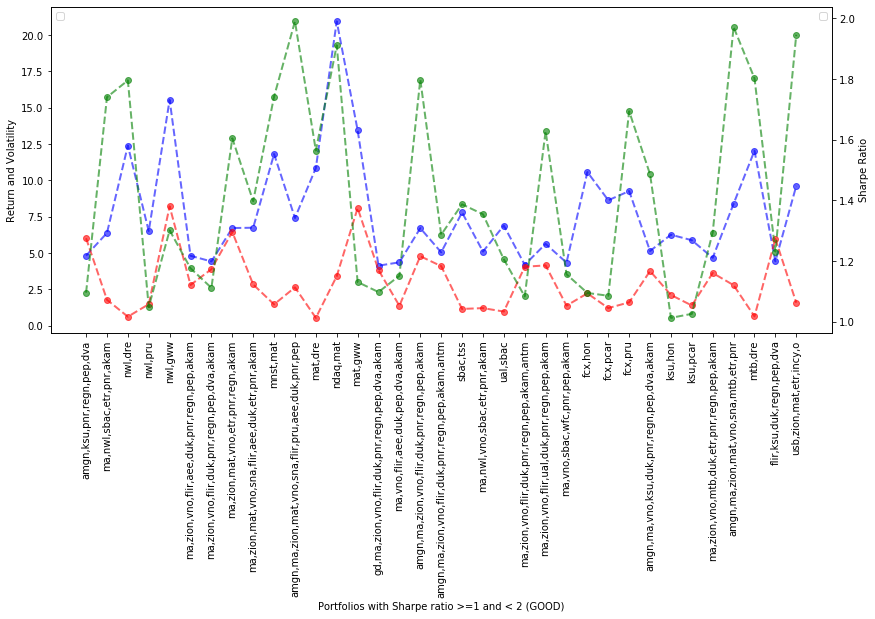

In [51]:
plt.figure(figsize=(14,5))
fig, ax1 = plt.subplots(figsize=(14,6))

ax2 = ax1.twinx()
ax2.plot(good['PortfolioL'], good['Sharpe Ratio'], 'g-', alpha=0.6, marker='o', 
         linestyle='dashed', linewidth=2, markersize=6)
ax1.plot(good['PortfolioL'], good['Portfolio Return'], 'b-', alpha=0.6, marker='o', 
         linestyle='dashed', linewidth=2, markersize=6)
ax1.plot(good['PortfolioL'],good['Portfolio Volatility'], 'r-', alpha=0.6, marker='o', 
         linestyle='dashed', linewidth=2, markersize=6)

ax1.set_xlabel('Portfolios with Sharpe ratio >=1 and < 2 (GOOD)')
ax1.set_ylabel('Return and Volatility')
ax2.set_ylabel('Sharpe Ratio')
ax1.xaxis.set_tick_params(rotation=90)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#ax2.set_alpha(0.4)
#ax1.set_alpha(0.4)
plt.show()

In [42]:
best = pd.DataFrame.from_dict(optim['best'])
best.columns = ['Portfolio', 'Weights', 'Sharpe Ratio']
portfolio_return = []

for row in best.iterrows():
    #print(row[1][0])
    mean = np.array(returns[row[1][0]].mean()) * len(returns)
    portfolio_weights = np.array(row[1][1])
    Rp = portfolio_weights.dot(mean.T) 
    portfolio_return.append(round(Rp * 100, 2))
    
best['Portfolio Return'] = portfolio_return

portfolio_volatility = []

for row in best.iterrows():
    portfolio = row[1][0]
    portfolio_weights = row[1][1]
    portfolio_data = data[portfolio]
    portfolio = portfolio_data.mul(portfolio_weights,axis=1).sum(axis=1)
    volatility = np.std(portfolio)
    portfolio_volatility.append(volatility)

best['Portfolio Volatility'] = portfolio_volatility
best

,Portfolio,Weights,Sharpe Ratio,Portfolio Return,Portfolio Volatility
0,"[amgn, ma, sna, mat]","[0.15477386934673368, 0.2793969849246231, 0.49...",3.710790,20.44,7.048145
1,"[amgn, ma, mtb, pep]","[0.07730426164519326, 0.43409316154608524, 0.0...",3.880803,10.93,3.011809
2,"[gd, ksu, dva, ma]","[0.11600587371512482, 0.24522760646108663, 0.0...",4.007066,13.03,3.374175
3,"[gd, ma, flir, ksu, duk, regn, pep, dva]","[0.035318924617817604, 0.24090669478123353, 0....",3.078995,7.23,3.783723
4,"[gd, rtn, ma, flir, ksu, dva]","[0.15478761699064075, 0.12958963282937366, 0.3...",3.453651,11.74,3.263088
5,"[gd, ma, sna, vno, flir, aee, ksu, duk, pep, dva]","[0.04311039484286865, 0.16720386784850927, 0.1...",3.309715,8.89,2.765992
6,"[gd, ma, sna, dre, vno, flir]","[0.08036292935839275, 0.27997407647440054, 0.2...",3.503266,16.21,4.003075
7,"[gd, ma, sna, vno, flir, re]","[0.054819277108433734, 0.18734939759036146, 0....",3.984087,18.07,6.253641
8,"[nwl, o]","[0.11070780399274047, 0.8892921960072595]",4.124338,21.42,2.868253
9,"[nwl, sna]","[0.09289617486338798, 0.907103825136612]",3.902181,27.29,9.244751


In [43]:
best['PortfolioL'] = best['Portfolio'].apply(lambda x: ','.join(map(str, x)))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


<Figure size 1008x360 with 0 Axes>

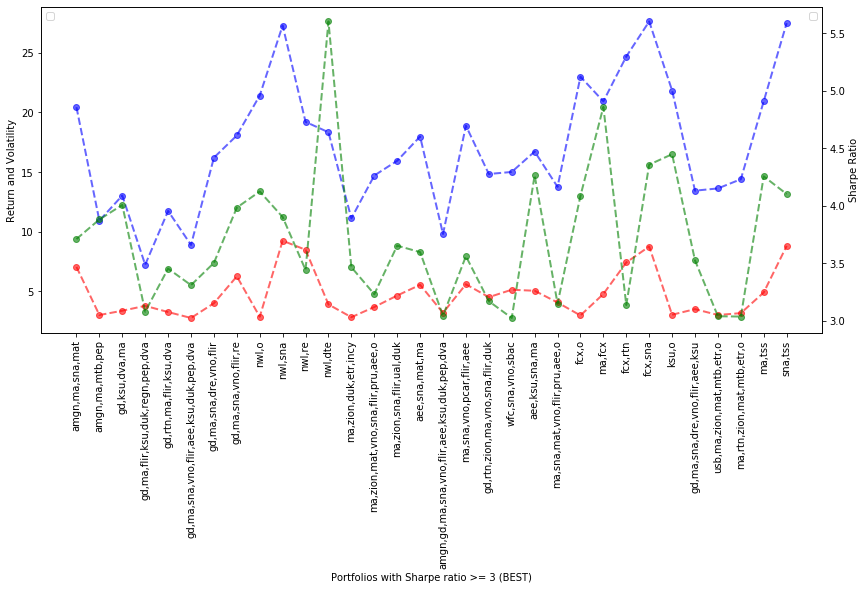

In [44]:
plt.figure(figsize=(14,5))
fig, ax1 = plt.subplots(figsize=(14,6))

ax2 = ax1.twinx()
ax2.plot(best['PortfolioL'], best['Sharpe Ratio'], 'g-', alpha=0.6, marker='o', 
         linestyle='dashed', linewidth=2, markersize=6)
ax1.plot(best['PortfolioL'], best['Portfolio Return'], 'b-', alpha=0.6, marker='o', 
         linestyle='dashed', linewidth=2, markersize=6)
ax1.plot(best['PortfolioL'],best['Portfolio Volatility'], 'r-', alpha=0.6, marker='o', 
         linestyle='dashed', linewidth=2, markersize=6)

ax1.set_xlabel('Portfolios with Sharpe ratio >= 3 (BEST)')
ax1.set_ylabel('Return and Volatility')
ax2.set_ylabel('Sharpe Ratio')
ax1.xaxis.set_tick_params(rotation=90)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

#ax2.set_alpha(0.4)
#ax1.set_alpha(0.4)
plt.show()

Volatility of a stock can be measured from it's standard deviation. The following code calculates standard deviation of each ticker for the taken time period. A higher volatililty means that the security is more risky. This means AMZN has the highest risk in the considered time period.


We calculate volatility of a portfolio in the 4 stocks picked by assigning random weights that add up to 1. Each close price value for a stock is multipled with its respective weight.
σPortfolio = Sqrt(wT⋅Σ⋅w)

In [52]:
def get_ticker_volatility(portfolio):
    tick_std = np.std(data[portfolio])
    print(tick_std)

In [53]:
get_ticker_volatility(better['Portfolio'][7])

nwl    0.87801
rtn    8.49211
dtype: float64


In [54]:
better['Portfolio Volatility'][7]

7.568514727850937